[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Linear_Regression_Physiological.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025.git
%cd /content/OP_2025/

# Download Data

In [ ]:
!mkdir omics_adata
!wget -O omics_adata/rat_RNA_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1


--2025-07-02 12:03:20--  https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1
Resolving data.caltech.edu (data.caltech.edu)... 35.155.11.48
Connecting to data.caltech.edu (data.caltech.edu)|35.155.11.48|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: /login/?next=%2Frecords%2Fj57wp-0pp06%2Ffiles%2Frat_RNA_meta.h5ad%3Fdownload%3D1 [following]
--2025-07-02 12:03:20--  https://data.caltech.edu/login/?next=%2Frecords%2Fj57wp-0pp06%2Ffiles%2Frat_RNA_meta.h5ad%3Fdownload%3D1
Reusing existing connection to data.caltech.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 4942 (4.8K) [text/html]
Saving to: ‘omics_adata/rat_RNA_meta.h5ad’

omics_adata/rat_RNA 100%[===================>]   4.83K  --.-KB/s    in 0s      

2025-07-02 12:03:21 (36.3 MB/s) - ‘omics_adata/rat_RNA_meta.h5ad’ saved [4942/4942]



# Install Packages

In [ ]:
!pip install -qr requirements.txt 

In [ ]:
import os, sys
sys.path.append('analysis_scripts')
import tempfile

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.linear_model 
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from rat_friend import *

In [24]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

## Initial Data Loading

In [ ]:
og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")

og_adata.obs.time = og_adata.obs.time.astype('int')

# normalized but not logged due to the meathematical assumptions underlying linear regression 
sc.pp.normalize_total(og_adata)

og_adata.layers["counts"] = og_adata.X.copy()
og_adata

AnnData object with n_obs × n_vars = 861 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

# Linear Regression to Predict Body Fat Change from RNA Counts

## Reshape Data by concatanting by individual

In [26]:
phy_oi = 'calculated.variables.pct_body_fat_change'

#filter out samples without data
adata = og_adata[~og_adata.obs[phy_oi].isna()]

X, y, z = data_reshaper_omic(adata, 
                             tiss_list = adata.obs.tissue.unique())
y = y.reset_index(drop=True)

SKM-GN
HYPOTH
CORTEX
WAT
BAT
BLOOD
SMLINT
COLON
ADRNL
KIDNEY
HIPPOC
HEART
SKM-VL
LIVER
LUNG
SPLEEN


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Run Ridge Regression

In [27]:
np.random.seed(0)

train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid').agg(lambda x: x.value_counts().index[0])
train_nids = train_filter.groupby(['time', 'sex']).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int'))).index.get_level_values(2).tolist()
ref_mask = [x in train_nids for x in y.nid]


X_train = X[ref_mask]
X_test = X[list(~np.array(ref_mask))]
y_train = y[ref_mask]
y_test = y[list(~np.array(ref_mask))]

X_train = X_train[~y_train[phy_oi].isna()]
X_test = X_test[~y_test[phy_oi].isna()]
y_train = y_train[~y_train[phy_oi].isna()]
y_test = y_test[~y_test[phy_oi].isna()]

# instantiate the model (using the default parameters)
model = sklearn.linear_model.Ridge(random_state=0)

# fit the model with data
model.fit(X_train, y_train[phy_oi])

y_pred = model.predict(X_test)
big_ccc = get_CCC(y_test[phy_oi], y_pred)
big_r2 = sklearn.metrics.r2_score(y_test[phy_oi], y_pred)

/tmp/ipykernel_1968168/1663650475.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid').agg(lambda x: x.value_counts().index[0])
/tmp/ipykernel_1968168/1663650475.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_nids = train_filter.groupby(['time', 'sex']).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int'))).index.get_level_values(2).tolist()
/tmp/ipykernel_1968168/1663650475.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pan

In [28]:
y[['time', 'sex', phy_oi]].groupby(['time', 'sex']).count()

/tmp/ipykernel_1968168/4040832591.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y[['time', 'sex', phy_oi]].groupby(['time', 'sex']).count()


calculated.variables.pct_body_fat_change
time sex                                             
0    female                                         3
     male                                           3
4    female                                         3
     male                                           5
8    female                                         5
     male                                           4

In [29]:
test_df = pd.DataFrame({'prediction' : y_pred,
                            'actual' : y_test[phy_oi],
                            'Sex': y_test.sex,
                            'time': y_test.time
                             })
test_df.index = y_test.nid
test_df['Subset'] = 'test'
train_df = pd.DataFrame({'prediction' : model.predict(X_train),
                            'actual' : y_train[phy_oi],
                            'Sex': y_train.sex,
                            'time': y_train.time
                             })
train_df.index = y_train.nid
train_df['Subset'] = 'train'
# save results
sig_coeff = pd.DataFrame({'coeff' : model.coef_.tolist(),
                          'abs_coeff': np.abs(model.coef_.tolist()),
                            'feature' : z.index.tolist(),
                          'tissue' : z.tissue.tolist(),
                         'feature_num' : range(0, z.shape[0])})
sig_coeff.to_csv('linear_regression_fat_coeffs.csv', index=False)
pd.concat([test_df, train_df]).to_csv('lin_reg_results_fat.csv')
sig_coeff.sort_values(by='abs_coeff',ascending=False).head(10)

,coeff,abs_coeff,feature,tissue,feature_num
98596,0.000006,0.000006,ENSRNOG00000013552_BAT,BAT,98596
85778,-0.000004,0.000004,ENSRNOG00000055596_WAT,WAT,85778
107523,-0.000004,0.000004,ENSRNOG00000049695_BAT,BAT,107523
124148,-0.000004,0.000004,ENSRNOG00000020951_BLOOD,BLOOD,124148
123218,-0.000004,0.000004,ENSRNOG00000019183_BLOOD,BLOOD,123218
122632,-0.000003,0.000003,ENSRNOG00000018053_BLOOD,BLOOD,122632
114832,0.000003,0.000003,ENSRNOG00000001633_BLOOD,BLOOD,114832
288860,0.000003,0.000003,ENSRNOG00000049695_SKM-VL,SKM-VL,288860
122522,-0.000003,0.000003,ENSRNOG00000017854_BLOOD,BLOOD,122522
118707,-0.000003,0.000003,ENSRNOG00000010037_BLOOD,BLOOD,118707


## Graph Results

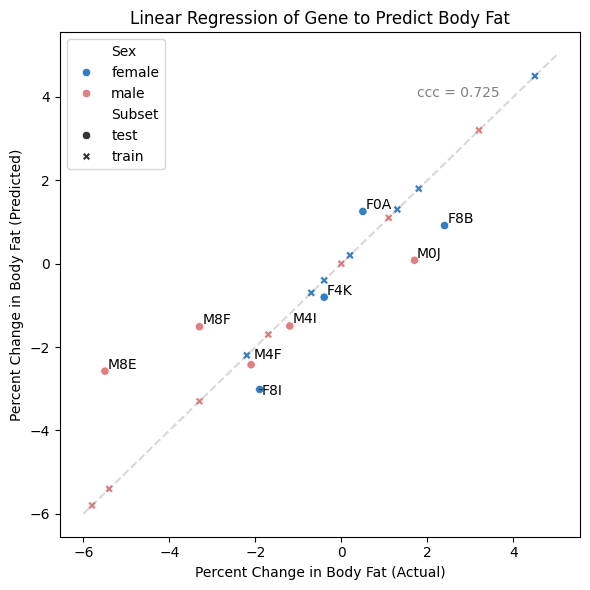

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(pd.concat([test_df, train_df]), x = 'actual', y = 'prediction', hue = 'Sex',style = 'Subset',
                   palette = color_dict
               )
plt.plot([-6, 5], [-6, 5], color = 'grey', alpha = .3, linestyle='--')
plt.text(1.75, 4, f'ccc = {round(big_ccc, 3)}', c = 'grey')
plt.xlabel('Percent Change in Body Fat (Actual)')
plt.ylabel('Percent Change in Body Fat (Predicted)')
plt.title('Linear Regression of Gene to Predict Body Fat')
from adjustText import adjust_text
texts=[]
for i,r in test_df.iterrows():
    texts.append(plt.text(x=r['actual'],y=r['prediction'],s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_8a.png')
plt.show()

# Linear Regression to predict VO $_2$ Max from Gene Expression

## Reshape Data

In [31]:
phy_oi = 'calculated.variables.vo2_max_change'

#filter out samples without data
adata = og_adata[~og_adata.obs[phy_oi].isna()]

X, y, z = data_reshaper_omic(adata, 
                             tiss_list = adata.obs.tissue.unique())
y = y.reset_index(drop=True)

SKM-GN
HYPOTH
CORTEX
WAT
BAT
BLOOD
SMLINT
COLON
ADRNL
KIDNEY
HIPPOC
HEART
SKM-VL
LIVER
LUNG
SPLEEN


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Run Ridge Regression

In [32]:
np.random.seed(0)

train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid').agg(lambda x: x.value_counts().index[0])
train_nids = train_filter.groupby(['time', 'sex']).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int'))).index.get_level_values(2).tolist()
ref_mask = [x in train_nids for x in y.nid]


X_train = X[ref_mask]
X_test = X[list(~np.array(ref_mask))]
y_train = y[ref_mask]
y_test = y[list(~np.array(ref_mask))]

X_train = X_train[~y_train[phy_oi].isna()]
X_test = X_test[~y_test[phy_oi].isna()]
y_train = y_train[~y_train[phy_oi].isna()]
y_test = y_test[~y_test[phy_oi].isna()]

# instantiate the model (using the default parameters)
model = sklearn.linear_model.Ridge(random_state=0)

# fit the model with data
model.fit(X_train, y_train[phy_oi])

y_pred = model.predict(X_test)
big_ccc = get_CCC(y_test[phy_oi], y_pred)
big_r2 = sklearn.metrics.r2_score(y_test[phy_oi], y_pred)

/tmp/ipykernel_1968168/1663650475.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid').agg(lambda x: x.value_counts().index[0])
/tmp/ipykernel_1968168/1663650475.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_nids = train_filter.groupby(['time', 'sex']).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int'))).index.get_level_values(2).tolist()
/tmp/ipykernel_1968168/1663650475.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pan

In [33]:
y[['time', 'sex', phy_oi]].groupby(['time', 'sex']).count()

/tmp/ipykernel_1968168/4040832591.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y[['time', 'sex', phy_oi]].groupby(['time', 'sex']).count()


calculated.variables.vo2_max_change
time sex                                        
0    female                                    3
     male                                      3
4    female                                    3
     male                                      5
8    female                                    5
     male                                      4

In [34]:
test_df = pd.DataFrame({'prediction' : y_pred,
                            'actual' : y_test[phy_oi],
                            'Sex': y_test.sex,
                            'time': y_test.time
                             })
test_df.index = y_test.nid
test_df['Subset'] = 'test'
train_df = pd.DataFrame({'prediction' : model.predict(X_train),
                            'actual' : y_train[phy_oi],
                            'Sex': y_train.sex,
                            'time': y_train.time
                             })
train_df.index = y_train.nid
train_df['Subset'] = 'train'
# save results
# save results
sig_coeff = pd.DataFrame({'coeff' : model.coef_.tolist(),
                          'abs_coeff': np.abs(model.coef_.tolist()),
                            'feature' : z.index.tolist(),
                          'tissue' : z.tissue.tolist(),
                         'feature_num' : range(0, z.shape[0])})
sig_coeff.to_csv('linear_regression_vo2_coeffs.csv', index=False)
pd.concat([test_df, train_df]).to_csv('lin_reg_results_vo2.csv')
sig_coeff.sort_values(by='abs_coeff',ascending=False).head(10)

,coeff,abs_coeff,feature,tissue,feature_num
98596,-0.000034,0.000034,ENSRNOG00000013552_BAT,BAT,98596
132633,0.000031,0.000031,ENSRNOG00000065867_BLOOD,BLOOD,132633
85778,0.000024,0.000024,ENSRNOG00000055596_WAT,WAT,85778
131202,0.000023,0.000023,ENSRNOG00000062930_BLOOD,BLOOD,131202
1855,0.000021,0.000021,ENSRNOG00000003897_SKM-GN,SKM-GN,1855
196487,-0.000020,0.000020,ENSRNOG00000045636_ADRNL,ADRNL,196487
114832,-0.000017,0.000017,ENSRNOG00000001633_BLOOD,BLOOD,114832
134780,-0.000016,0.000016,ENSRNOG00000070284_BLOOD,BLOOD,134780
132740,-0.000015,0.000015,ENSRNOG00000066088_BLOOD,BLOOD,132740
275647,0.000015,0.000015,ENSRNOG00000004583_SKM-VL,SKM-VL,275647


## Graph Results

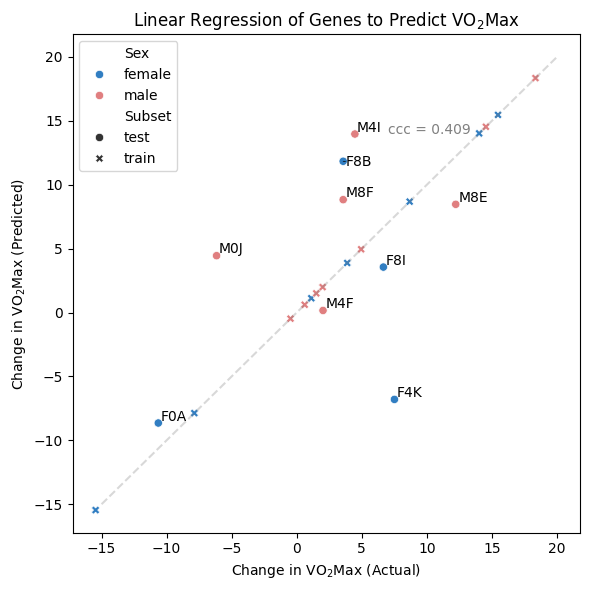

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(pd.concat([test_df, train_df]), x = 'actual', y = 'prediction', hue = 'Sex',style = 'Subset',
                   palette = color_dict
               )
plt.plot([-15, 20], [-15, 20], color = 'grey', alpha = .3, linestyle='--')
plt.text(7, 14, f'ccc = {round(big_ccc, 3)}', c = 'grey')
plt.xlabel('Change in VO$_2$Max (Actual)')
plt.ylabel('Change in VO$_2$Max (Predicted)')
plt.title('Linear Regression of Genes to Predict VO$_2$Max')
from adjustText import adjust_text
texts=[]
for i,r in test_df.iterrows():
    texts.append(plt.text(x=r['actual'],y=r['prediction'],s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_8b.png')
plt.show()
pd.concat([test_df, train_df]).to_csv('metadata_csvs/lin_reg_results_vo2.csv')


# Compare Top Gene Coeffecients between Prediction of Time and Fat

In [ ]:
fat_coeff = pd.read_csv('metadata_csvs/linear_regression_fat_coeffs.csv')
time_coeff = pd.read_csv('metadata_csvs/linear_regression_time_coeffs.csv')
comb_df = pd.merge(fat_coeff, time_coeff, on = ['feature', 'tissue'], suffixes=('_fat', '_time'))
comb_df.head()

,coeff_fat,abs_coeff_fat,feature,tissue,feature_num_fat,coeff_time,abs_coeff_time,feature_num_time
0,1.403952e-09,1.403952e-09,ENSRNOG00000000001_SKM-GN,SKM-GN,0,1.005560e-09,1.005560e-09,0
1,-2.221608e-10,2.221608e-10,ENSRNOG00000000007_SKM-GN,SKM-GN,1,1.897881e-09,1.897881e-09,1
2,-3.646052e-10,3.646052e-10,ENSRNOG00000000008_SKM-GN,SKM-GN,2,1.312582e-09,1.312582e-09,2
3,8.005211e-11,8.005211e-11,ENSRNOG00000000009_SKM-GN,SKM-GN,3,5.731833e-10,5.731833e-10,3
4,-4.458323e-11,4.458323e-11,ENSRNOG00000000010_SKM-GN,SKM-GN,4,2.549074e-10,2.549074e-10,4


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/adjustText/__init__.py:419: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.figure.draw_without_rendering()


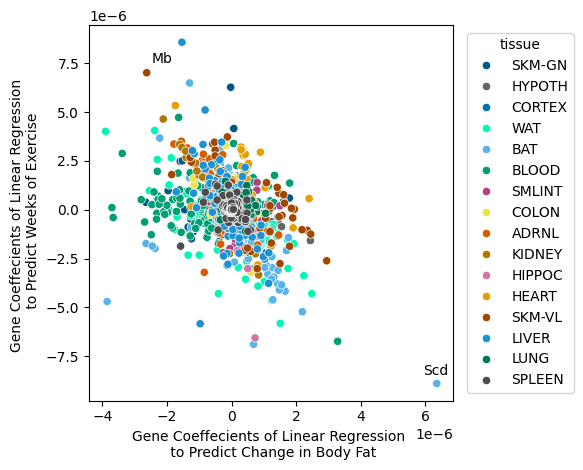

In [37]:
filt_df = comb_df#[(comb_df.abs_coeff_fat > 2e-6) | (comb_df.abs_coeff_time > 2e-6)]
ax = sns.scatterplot(filt_df, x = 'coeff_fat', y = 'coeff_time', hue = 'tissue',
                    palette = color_dict)
x

texts = [plt.text(x=-2.626972e-06, y=0.000007, s='Mb'),
        plt.text(x=5.750932e-06, y=-0.000009, s='Scd'),
        ]
adjust_text(texts, expand=(2, 2),
            
            #arrowprops=dict(arrowstyle="->", color='black')
           )
plt.ylabel('Gene Coeffecients of Linear Regression \n to Predict Weeks of Exercise')
plt.xlabel('Gene Coeffecients of Linear Regression \n to Predict Change in Body Fat')
sns.move_legend(ax, 'right', bbox_to_anchor=(1.35, .5))
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_9.png')
plt.show()